# 🫀 MFCC Pipeline with Pre‑Filtering & Visualisations
This notebook processes a heart‑sound **WAV** recording through:
1. High‑pass (≥20 Hz) & low‑pass (≤400 Hz) Butterworth filters
2. Savitzky‑Golay smoothing
3. Full MFCC extraction with visual plots at every stage

👉 **Edit `record_path` in the first cell** to point to your file, then run all cells.

Loaded: /Users/omarhassan/Downloads/13918_AV.wav
fs = 2000 Hz,  length = 20576 samples


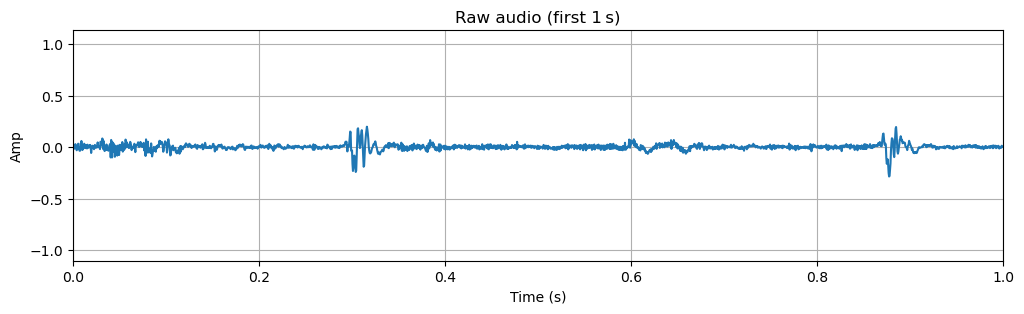

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, scipy.signal as sg
from scipy.fft import rfft
from scipy.fftpack import dct

# 1️⃣ Load recording (mono) & resample to 2 kHz
record_path = '/Users/omarhassan/Downloads/13918_AV.wav'   # ← CHANGE ME
signal, fs = librosa.load(record_path, sr=2000)
print('Loaded:', record_path)
print('fs =', fs, 'Hz,  length =', len(signal), 'samples')

# Plot raw waveform (first second)
plt.figure(figsize=(12,3))
t = np.arange(len(signal))/fs
plt.plot(t, signal)
plt.xlim(0, min(1, t[-1])); plt.xlabel('Time (s)'); plt.ylabel('Amp')
plt.title('Raw audio (first 1 s)'); plt.grid(True); plt.show()

Filtered signal shape: (20576,)


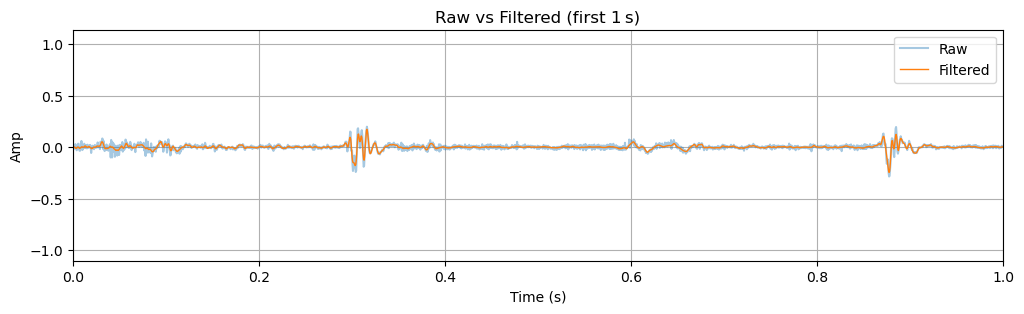

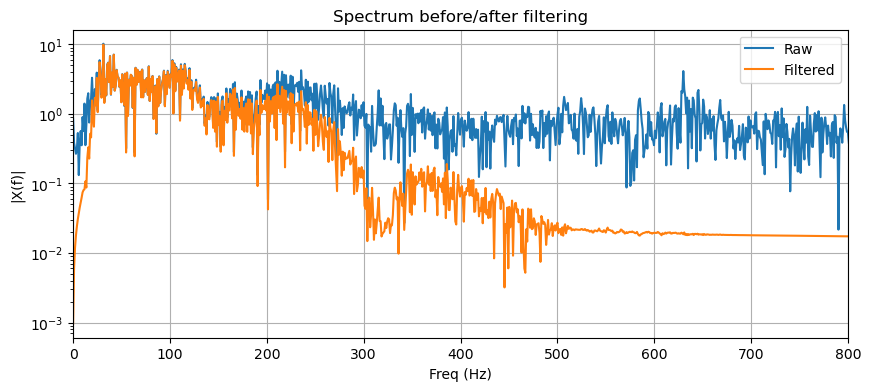

In [2]:
# 2️⃣ Pre‑filtering: HPF 20 Hz → LPF 400 Hz → Savitzky‑Golay
hp_cut, lp_cut = 20, 400   # Hz
hpf_b, hpf_a = sg.butter(4, hp_cut/(fs/2), btype='high')
lpf_b, lpf_a = sg.butter(4, lp_cut/(fs/2), btype='low')

filtered = sg.filtfilt(hpf_b, hpf_a, signal)
filtered = sg.filtfilt(lpf_b, lpf_a, filtered)

# Savitzky‑Golay (window 11, poly 3) smooth
filtered = sg.savgol_filter(filtered, window_length=11, polyorder=3)

print('Filtered signal shape:', filtered.shape)

# ── visualise waveform before/after (first sec) ──
plt.figure(figsize=(12,3))
plt.plot(t, signal, label='Raw', alpha=0.4)
plt.plot(t, filtered, label='Filtered', linewidth=1)
plt.xlim(0, min(1, t[-1])); plt.xlabel('Time (s)'); plt.ylabel('Amp')
plt.title('Raw vs Filtered (first 1 s)'); plt.legend(); plt.grid(True); plt.show()

# ── spectra before & after (whole recording) ──
n_fft = 2048
freqs = np.linspace(0, fs/2, n_fft//2+1)
raw_spec = np.abs(rfft(signal, n=n_fft))
filt_spec = np.abs(rfft(filtered, n=n_fft))

plt.figure(figsize=(10,4))
plt.semilogy(freqs, raw_spec[:len(freqs)], label='Raw')
plt.semilogy(freqs, filt_spec[:len(freqs)], label='Filtered')
plt.xlim(0, 800); plt.xlabel('Freq (Hz)'); plt.ylabel('|X(f)|')
plt.title('Spectrum before/after filtering'); plt.legend(); plt.grid(True); plt.show()

# Continue pipeline using `filtered` as new signal
signal = filtered

frames.shape = (513, 80)


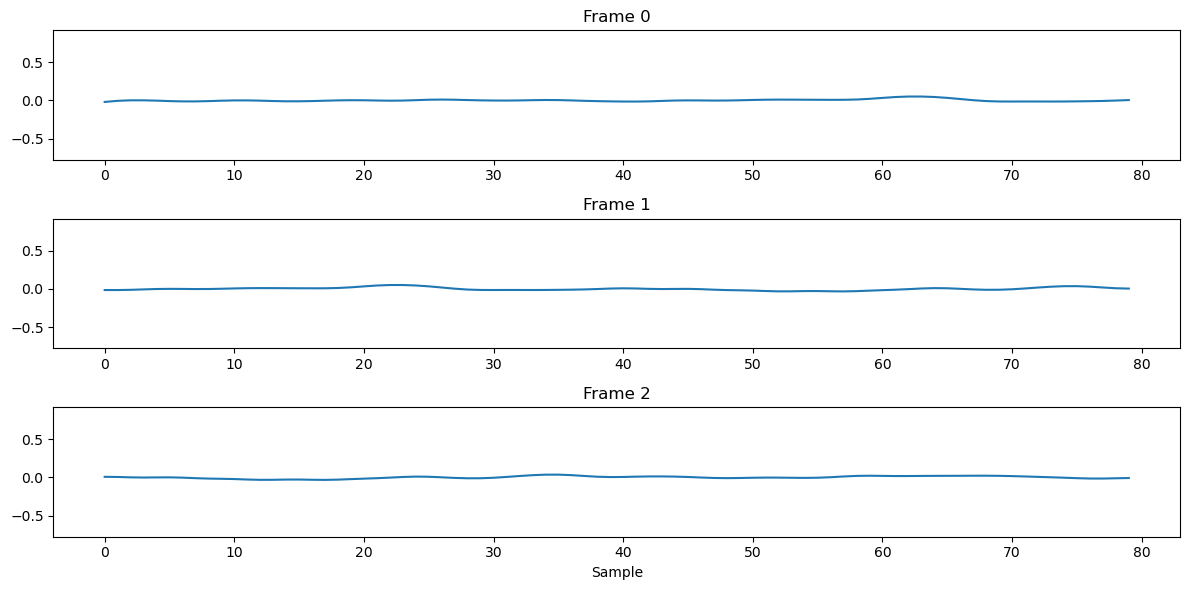

In [3]:
# 3️⃣ Frame the signal
frame_dur, hop_dur = 0.04, 0.02  # 40 ms / 20 ms
N = int(frame_dur * fs)
H = int(hop_dur  * fs)
num_frames = 1 + (len(signal)-N)//H
idx = np.arange(N)[None,:] + H*np.arange(num_frames)[:,None]
frames = signal[idx]
print('frames.shape =', frames.shape)

# Visualise first 3 frames
num_show = min(3, num_frames)
plt.figure(figsize=(12,2*num_show))
for i in range(num_show):
    plt.subplot(num_show,1,i+1)
    plt.plot(frames[i]); plt.title(f'Frame {i}')
    plt.ylim(signal.min(), signal.max())
plt.xlabel('Sample'); plt.tight_layout(); plt.show()

windowed_frames.shape = (513, 80)


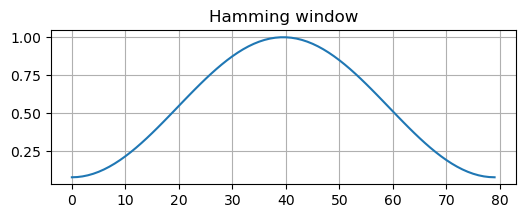

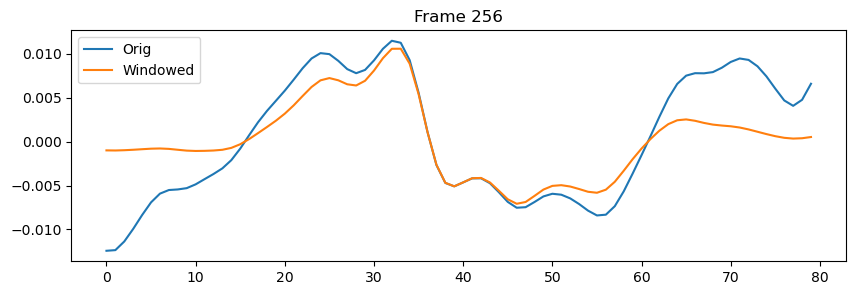

In [4]:
# 4️⃣ Hamming window
hamming = np.hamming(N)
windowed_frames = frames * hamming
print('windowed_frames.shape =', windowed_frames.shape)

# window plot
plt.figure(figsize=(6,2)); plt.plot(hamming)
plt.title('Hamming window'); plt.grid(True); plt.show()

frame_idx = num_frames//2
plt.figure(figsize=(10,3))
plt.plot(frames[frame_idx], label='Orig')
plt.plot(windowed_frames[frame_idx], label='Windowed')
plt.title(f'Frame {frame_idx}'); plt.legend(); plt.show()

fft_frames.shape = (513, 65)


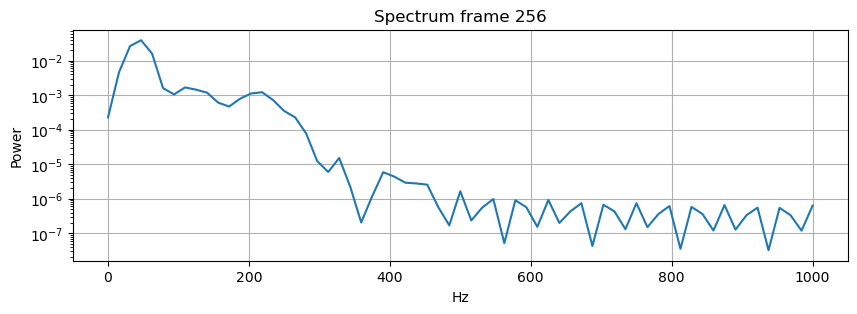

In [5]:
# 5️⃣ FFT
n_fft_small = 128
freq_bins = n_fft_small//2+1
fft_frames = rfft(windowed_frames, n=n_fft_small)
print('fft_frames.shape =', fft_frames.shape)

frame_idx = num_frames//2
freqs_small = np.linspace(0, fs/2, freq_bins)
plt.figure(figsize=(10,3))
plt.semilogy(freqs_small, np.abs(fft_frames[frame_idx])**2)
plt.xlabel('Hz'); plt.ylabel('Power'); plt.title(f'Spectrum frame {frame_idx}')
plt.grid(True); plt.show()

In [6]:
# 6️⃣ Power spectrum
power_frames = np.abs(fft_frames)**2
print('power_frames.shape =', power_frames.shape)

power_frames.shape = (513, 65)


mel_energy.shape = (513, 10)


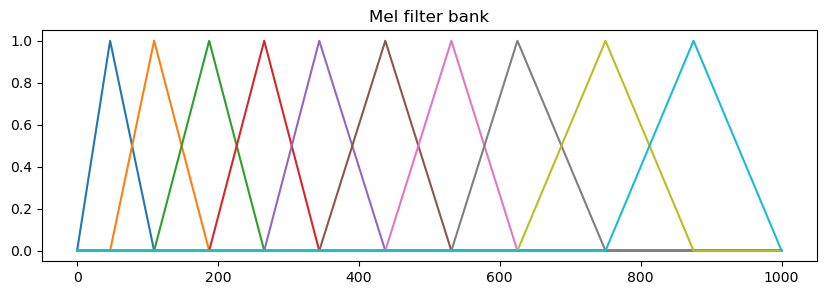

In [12]:
# 7️⃣ Mel projection
def hz2mel(f): return 2595*np.log10(1+f/700)
def mel2hz(m): return 700*(10**(m/2595)-1)

n_mels = 10
mel_pts = np.linspace(hz2mel(0), hz2mel(fs/2), n_mels+2)
hz_pts  = mel2hz(mel_pts)
bin_pts = np.floor((n_fft_small+1)*hz_pts/fs).astype(int)

filter_bank = np.zeros((n_mels, freq_bins))
for m in range(1,n_mels+1):
    l,c,r = bin_pts[m-1:m+2]
    for k in range(l,c): filter_bank[m-1,k]=(k-l)/(c-l)
    for k in range(c,r): filter_bank[m-1,k]=(r-k)/(r-c)

mel_energy = power_frames @ filter_bank.T
print('mel_energy.shape =', mel_energy.shape)

# mel filter shapes
plt.figure(figsize=(10,3))
for i in range(n_mels):
    plt.plot(freqs_small, filter_bank[i])
plt.title('Mel filter bank'); plt.show()

 

log_energy.shape = (513, 10)


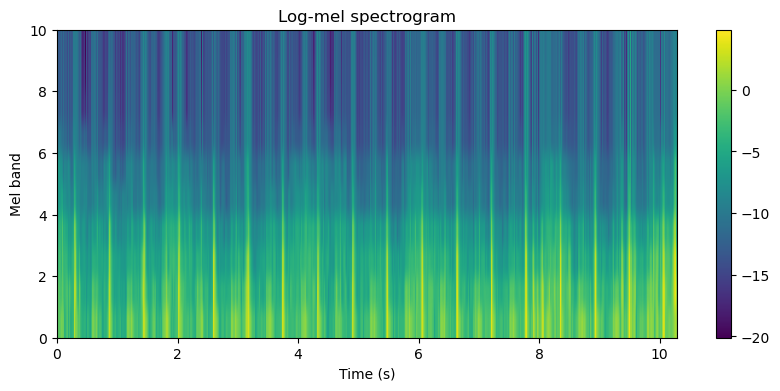

In [8]:
# 8️⃣ Log compression
log_energy = np.log(np.maximum(mel_energy,1e-12))
print('log_energy.shape =', log_energy.shape)

plt.figure(figsize=(10,4))
plt.imshow(log_energy.T, aspect='auto', origin='lower',
           extent=[0,len(signal)/fs,0,n_mels], cmap='viridis')
plt.xlabel('Time (s)'); plt.ylabel('Mel band')
plt.title('Log-mel spectrogram'); plt.colorbar(); plt.show()

mfcc.shape = (513, 10)


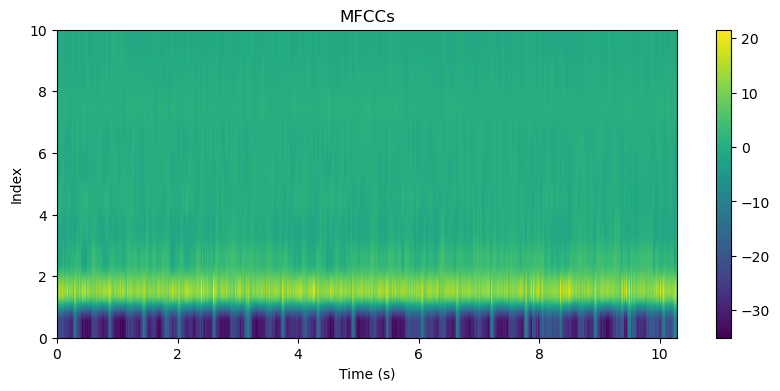

In [9]:
# 9️⃣ DCT → MFCC
K=10
mfcc = dct(log_energy, type=2, axis=1, norm='ortho')[:,:K]
print('mfcc.shape =', mfcc.shape)

plt.figure(figsize=(10,4))
plt.imshow(mfcc.T, aspect='auto', origin='lower',
           extent=[0,len(signal)/fs,0,K], cmap='viridis')
plt.colorbar(); plt.title('MFCCs'); plt.xlabel('Time (s)'); plt.ylabel('Index'); plt.show()